In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('../datasets/pets', target_types='segmentation', download=True)

100%|██████████| 791918971/791918971 [00:26<00:00, 29984314.03it/s]


Extracting ../datasets/pets/oxford-iiit-pet/images.tar.gz to ../datasets/pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16306995.04it/s]


Extracting ../datasets/pets/oxford-iiit-pet/annotations.tar.gz to ../datasets/pets/oxford-iiit-pet


In [3]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [4]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [5]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
#!g1.1
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [7]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [20]:
#!g1.1
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, 32)
        self.down2 = conv_plus_conv(32, 64)
        self.down3 = conv_plus_conv(64, 128)
        self.down4 = conv_plus_conv(128, 256)
        self.down5 = conv_plus_conv(256, 512)

        self.up1 = conv_plus_conv(160, base_channels)
        self.up2 = conv_plus_conv(320, 128)
        self.up3 = conv_plus_conv(640, 256)
        self.up4 = conv_plus_conv(768, 512)
        self.up5 = conv_plus_conv(1024, 512)

        self.bottleneck = conv_plus_conv(512, 512)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, 32)
        x = self.downsample(residual1)  # x.shape: (N, N, 32) -> (N // 2, N // 2, 32)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, 32) -> (N // 2, N // 2, 64)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, 64) -> (N // 4, N // 4, 64)
        
        residual3 = self.down3(x) # x.shape: (N // 4, N // 4, 64) -> (N // 4, N // 4, 128)
        x = self.downsample(residual3)  # x.shape: (N // 4, N // 4, 128 -> (N // 8, N // 8, 128)
        
        residual4 = self.down4(x) # x.shape: (N // 8, N // 8, 128) -> (N // 8, N // 8, 256)
        x = self.downsample(residual4) # x.shape: (N // 8, N // 8, 256) -> (N // 16, N // 16, 256)
        
        residual5 = self.down5(x) # x.shape: (N // 16, N // 16, 256) -> (N // 16, N // 16, 512)
        x = self.downsample(residual5) # x.shape: (N // 16, N // 16, 512) -> (N // 32, N // 32, 512)

        # LATENT SPACE DIMENSION DIM = N // 32
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 32, N // 32, 512) -> (N // 32, N // 32, 512)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 32
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 32, N // 32, 512) -> (N // 16, N // 16, 512)
        x = torch.cat((x, residual5), dim=1)  # x.shape: (N // 16, N // 16, base_channels 512) -> (N // 16, N // 16, 1024)
        x = self.up5(x) # x.shape: (N // 8, N // 8, 1024 -> (N // 16, N // 16, 512)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, 512) -> (N // 8, N // 8, 512)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 8, N // 8, 512) -> (N // 8, N // 8, 768)
        x = self.up4(x) # x.shape: (N // 8, N // 8, 768) -> (N // 8, N // 8, 512)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, 512) -> (N // 4, N // 4, 512)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, 512) -> (N // 4, N // 4, 640)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, 640) -> (N // 4, N // 4, 256)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, 256) -> (N // 2, N // 2, 256)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, 256) -> (N // 2, N // 2, 320)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, 320) -> (N // 2, N // 2, 128)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, 128) -> (N, N, 128)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, 128) -> (N, N, 256)
        x = self.up1(x)  # x.shape: (N, N, 256) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [18]:
#!g1.1
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 6)
        self.down5 = conv_plus_conv(base_channels * 6, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 6, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 8, base_channels * 3)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 4)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        
        residual3 = self.down3(x) # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)
        
        residual4 = self.down4(x) # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 6)
        x = self.downsample(residual4) # x.shape: (N // 8, N // 8, base_channels * 6) -> (N // 16, N // 16, base_channels * 6)
        
        residual5 = self.down5(x) # x.shape: (N // 16, N // 16, base_channels * 6) -> (N // 16, N // 16, base_channels * 8)
        x = self.downsample(residual5) # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 32, N // 32, base_channels * 8)

        # LATENT SPACE DIMENSION DIM = N // 16
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 4)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 16

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)
        x = torch.cat((x, residual5), dim=1)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8)
        x = self.up4(x) # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 8, N // 8, base_channels * 3)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels * 3) -> (N // 4, N // 4, base_channels * 3)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 4, N // 4, base_channels * 3) -> (N // 4, N // 4, base_channels * 6)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 6) -> (N // 4, N // 4, base_channels * 2)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [9]:
#!g1.1
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('../datasets/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('../datasets/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [29]:
#!g1.1
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [15]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [24]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

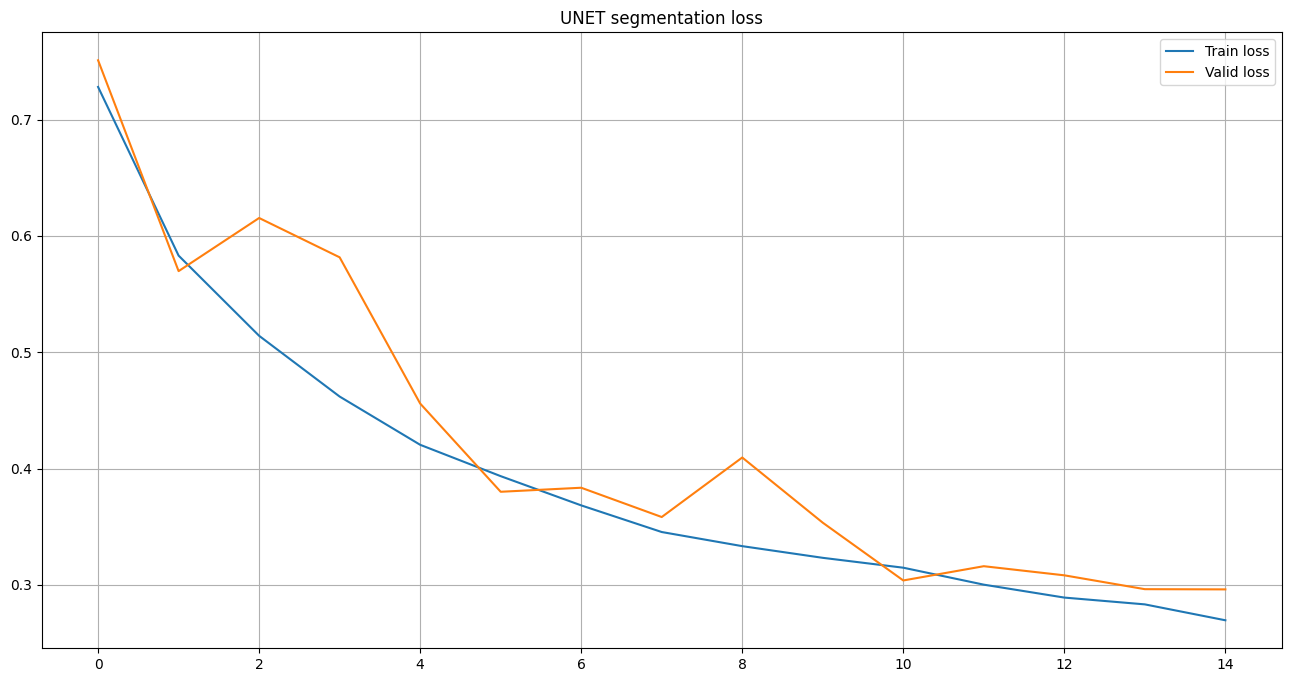

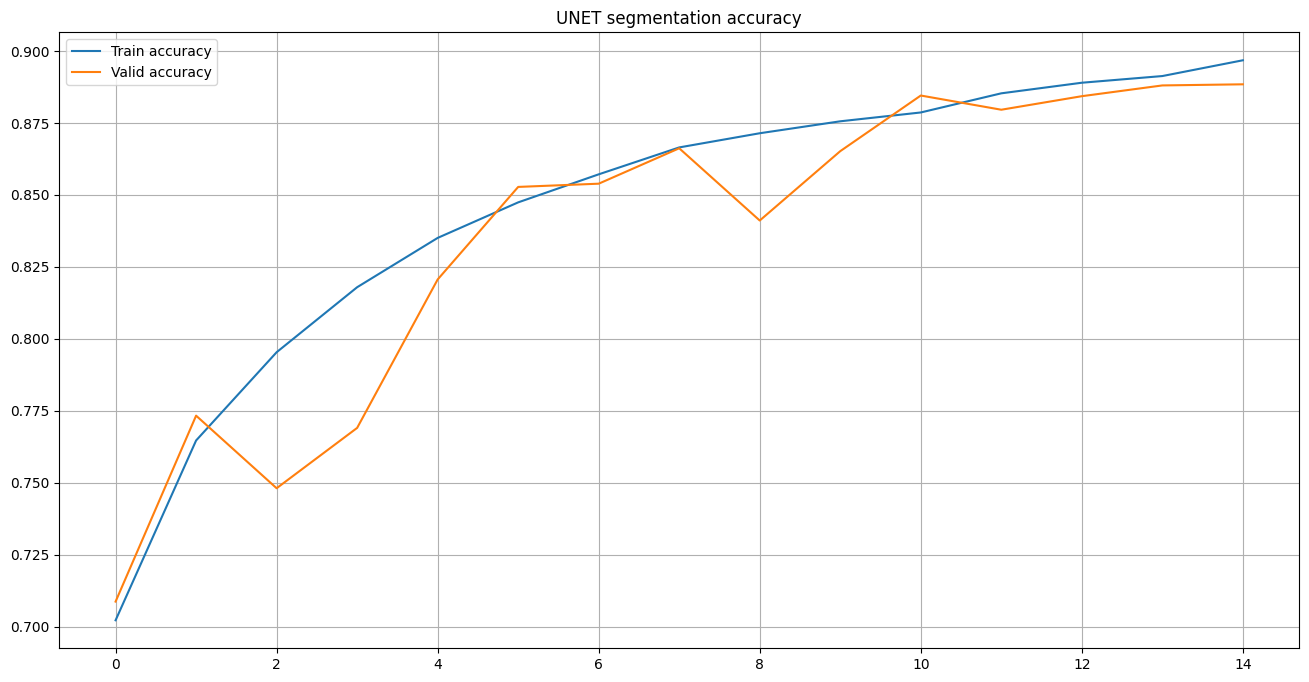

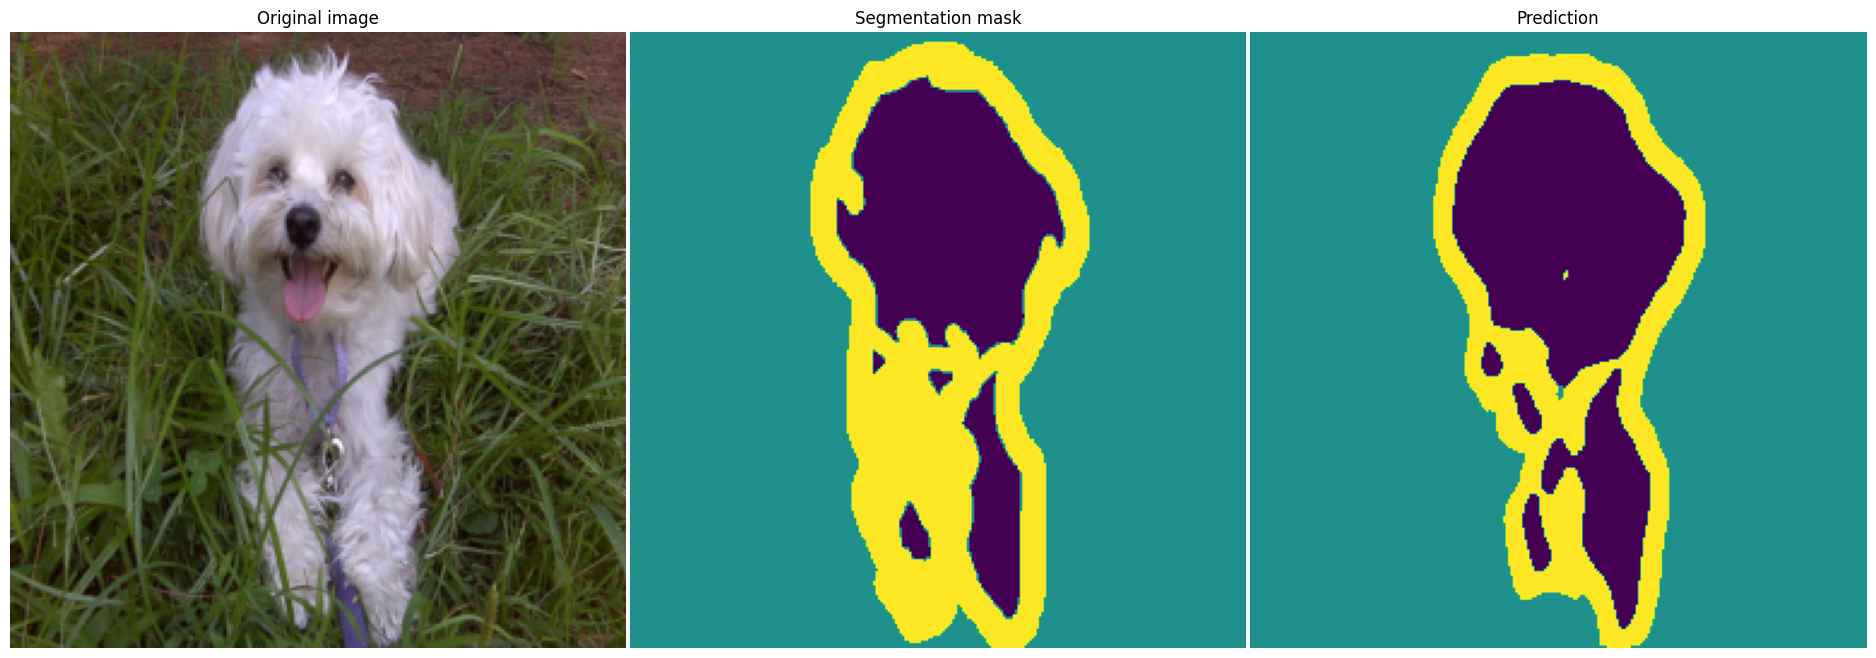

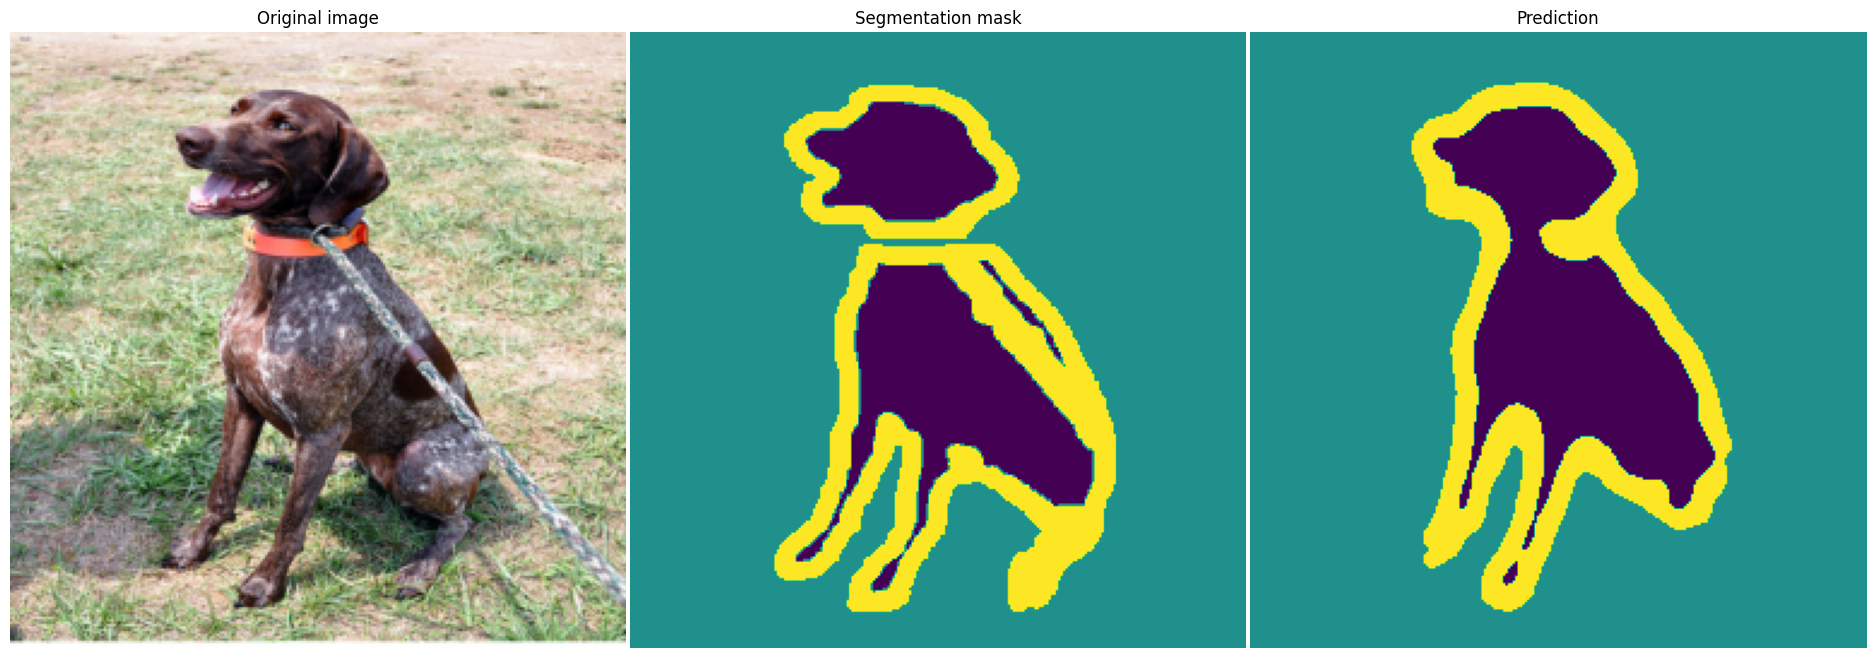

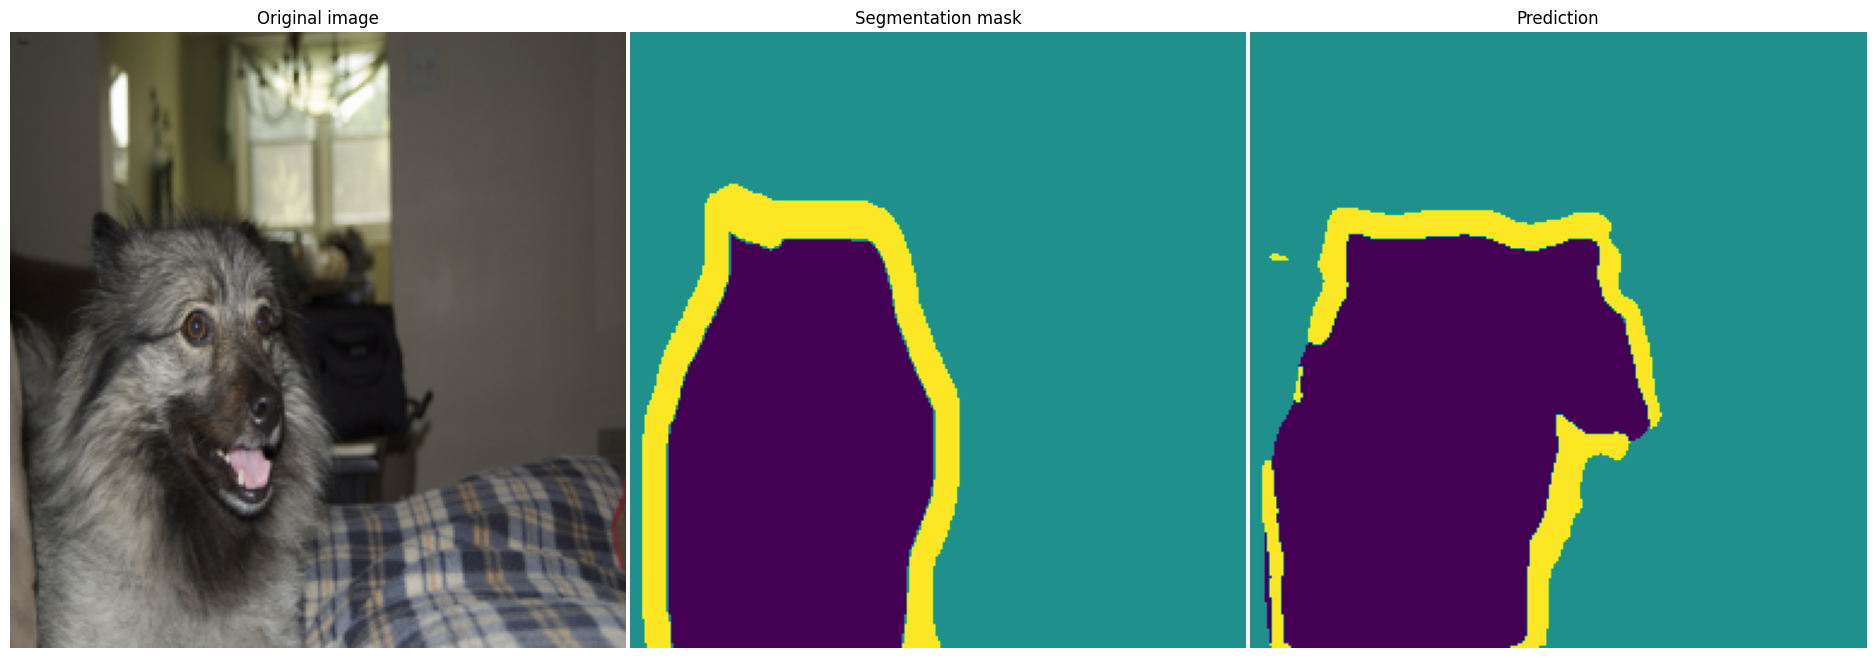

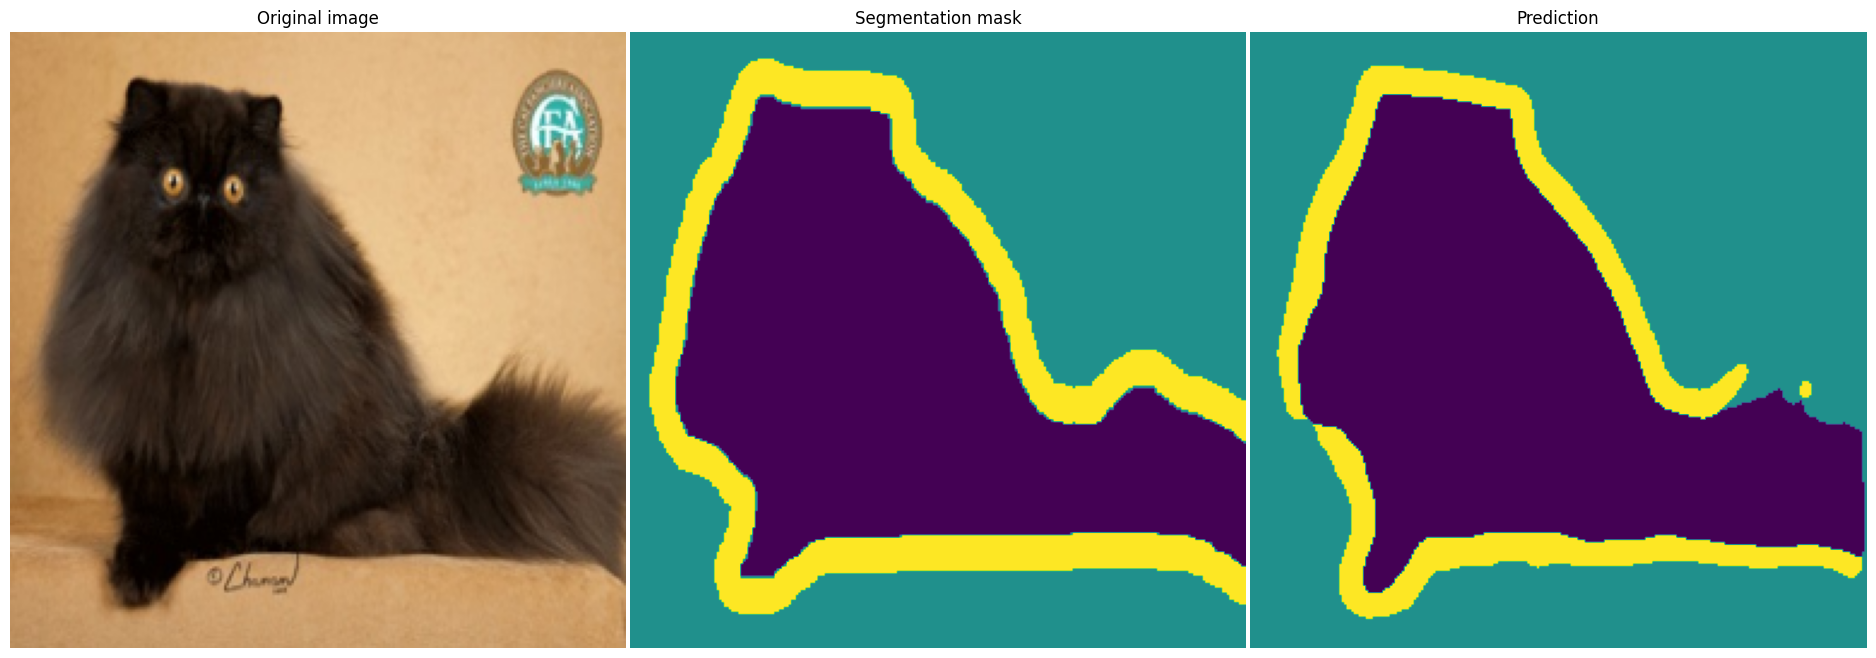

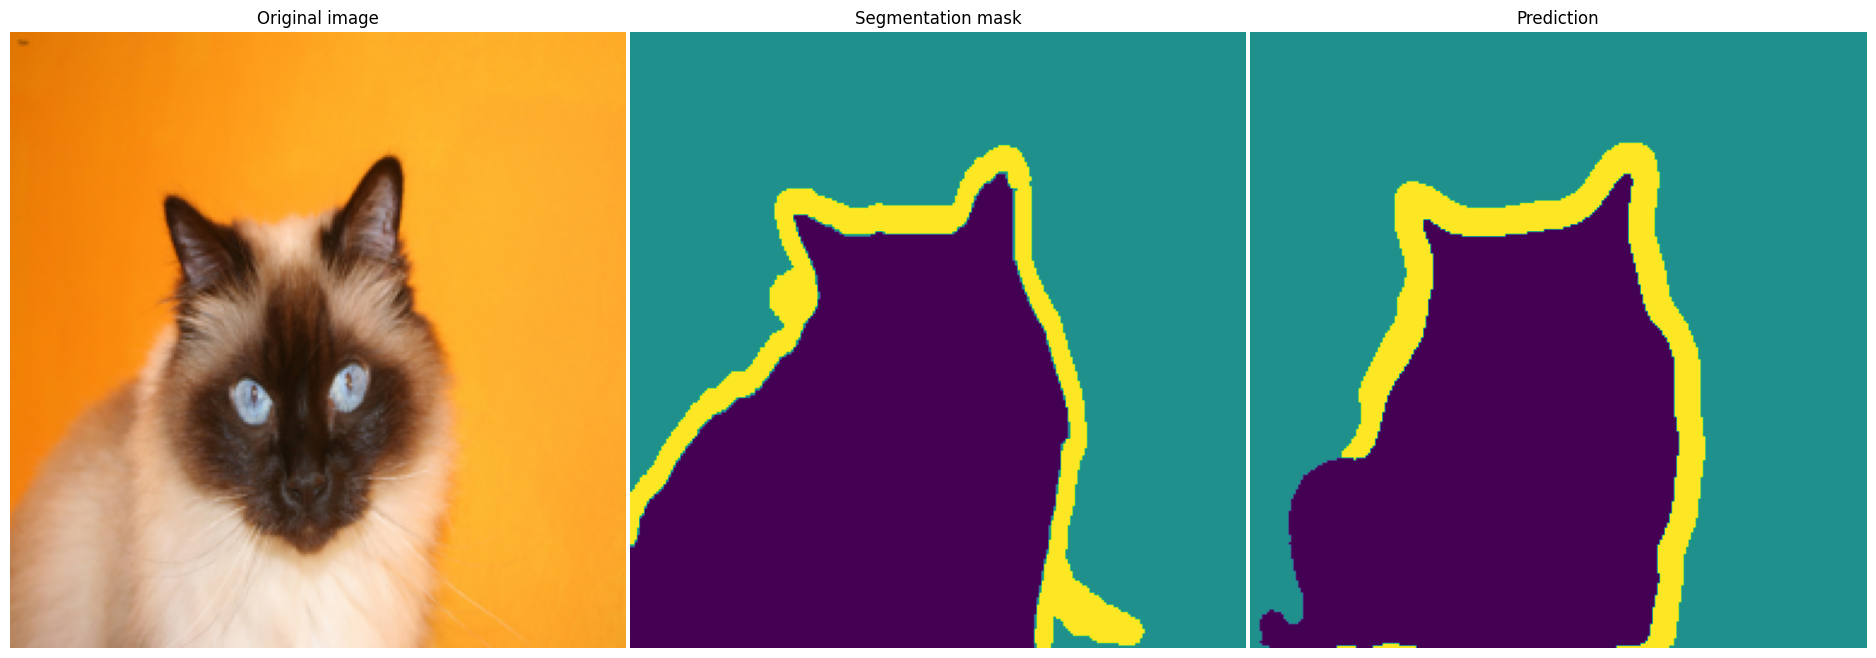

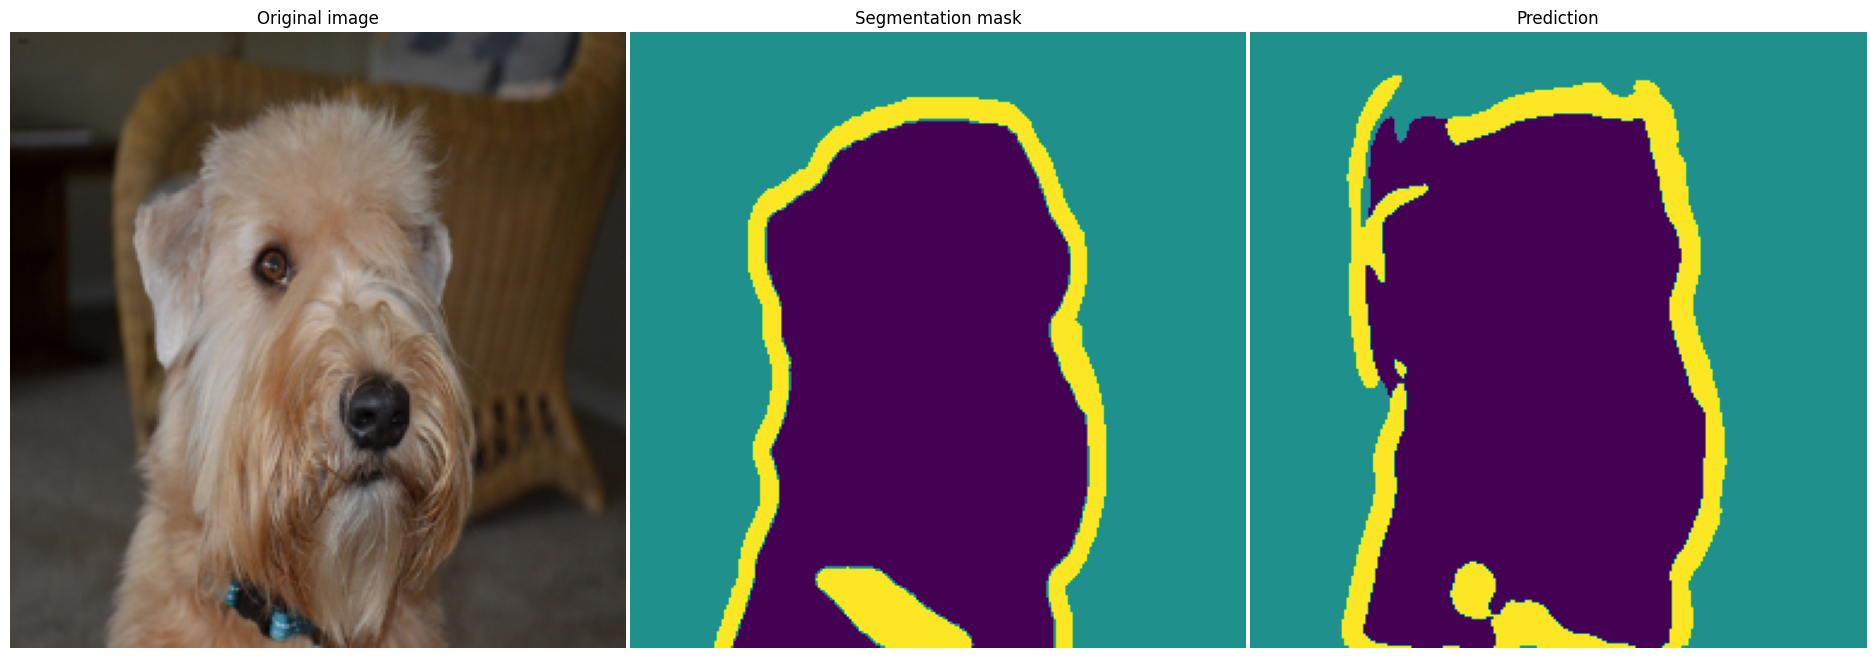

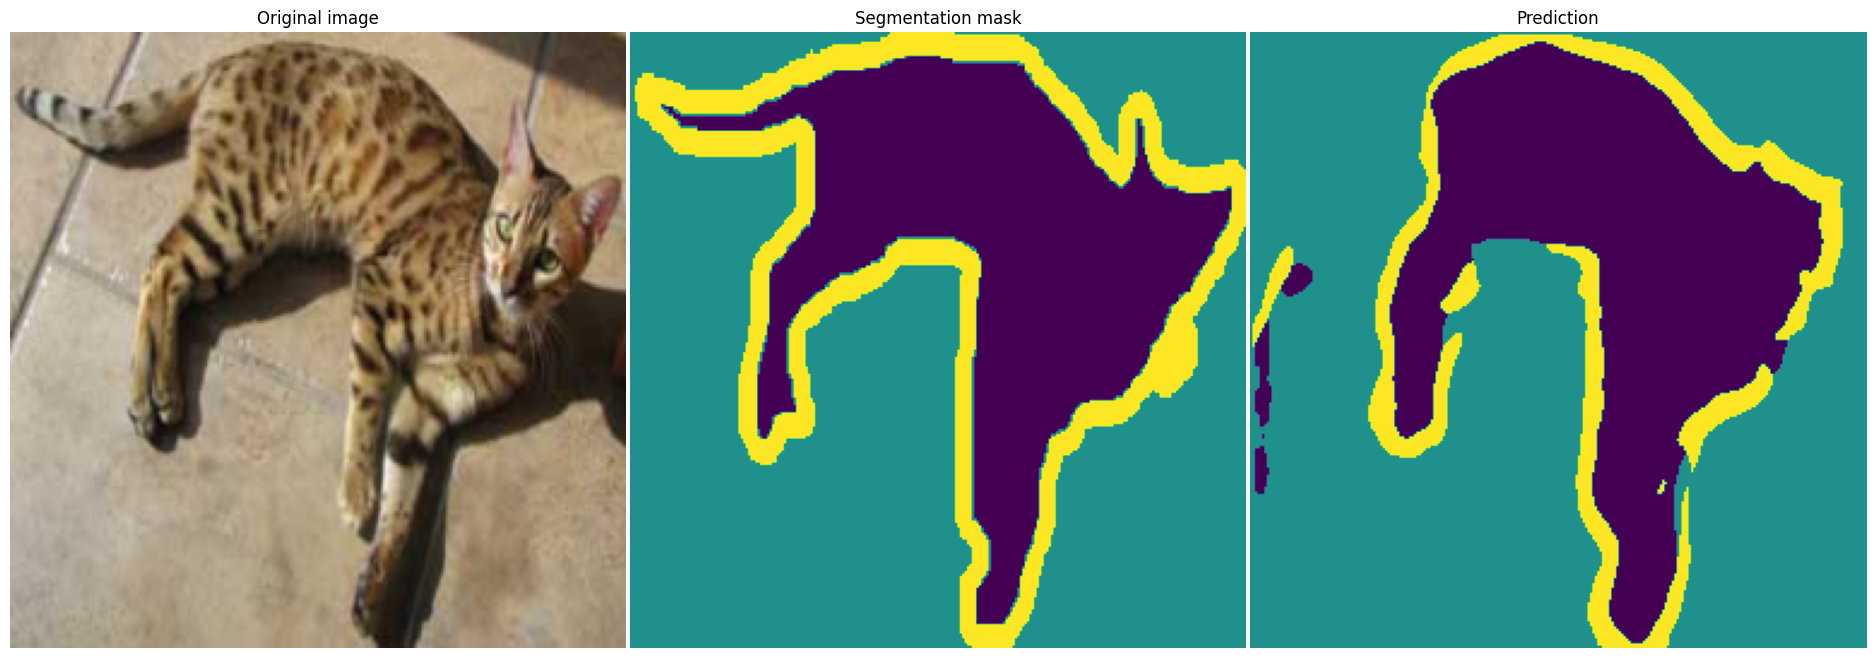

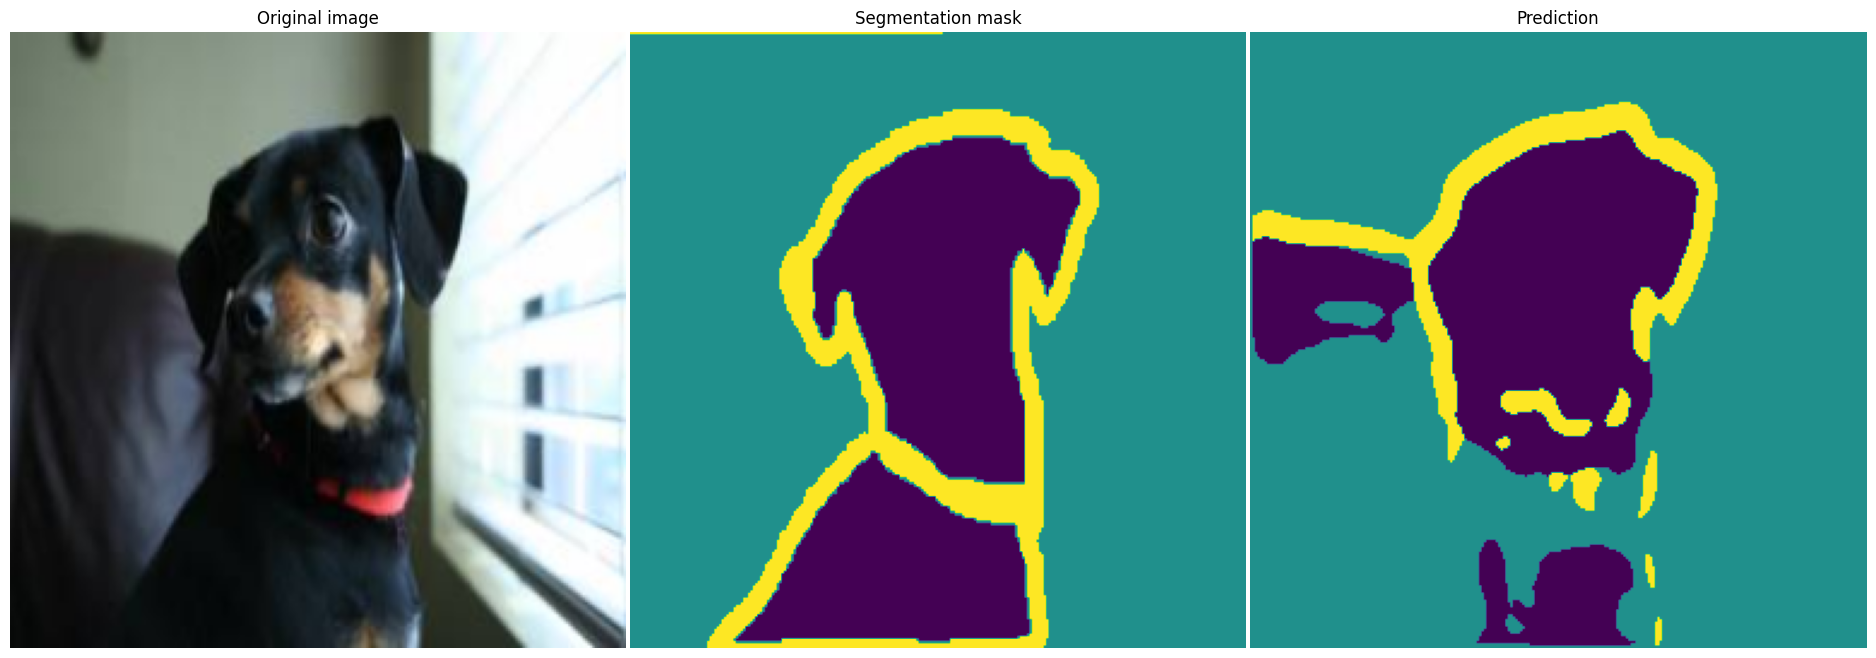

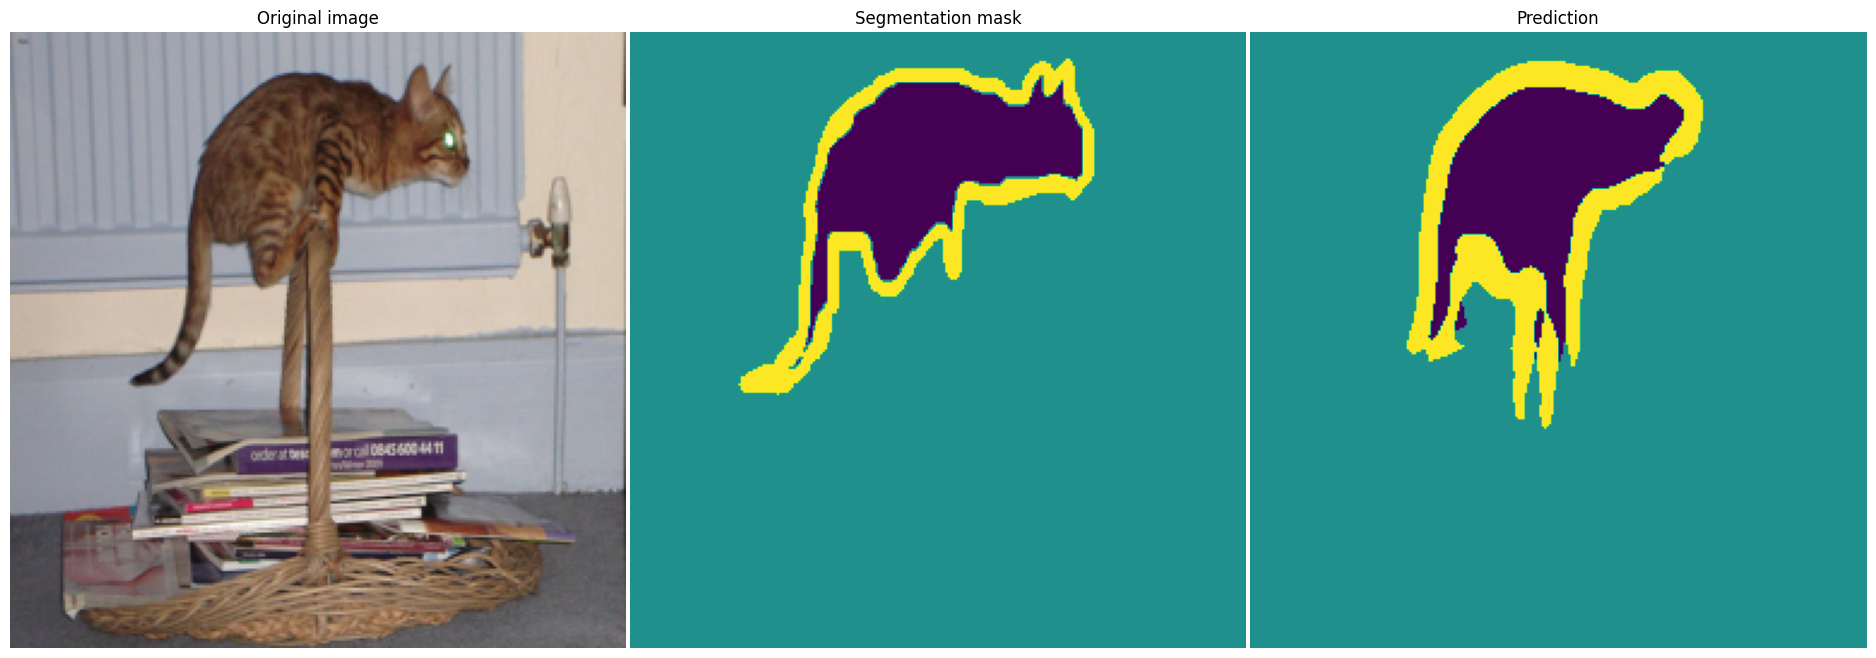

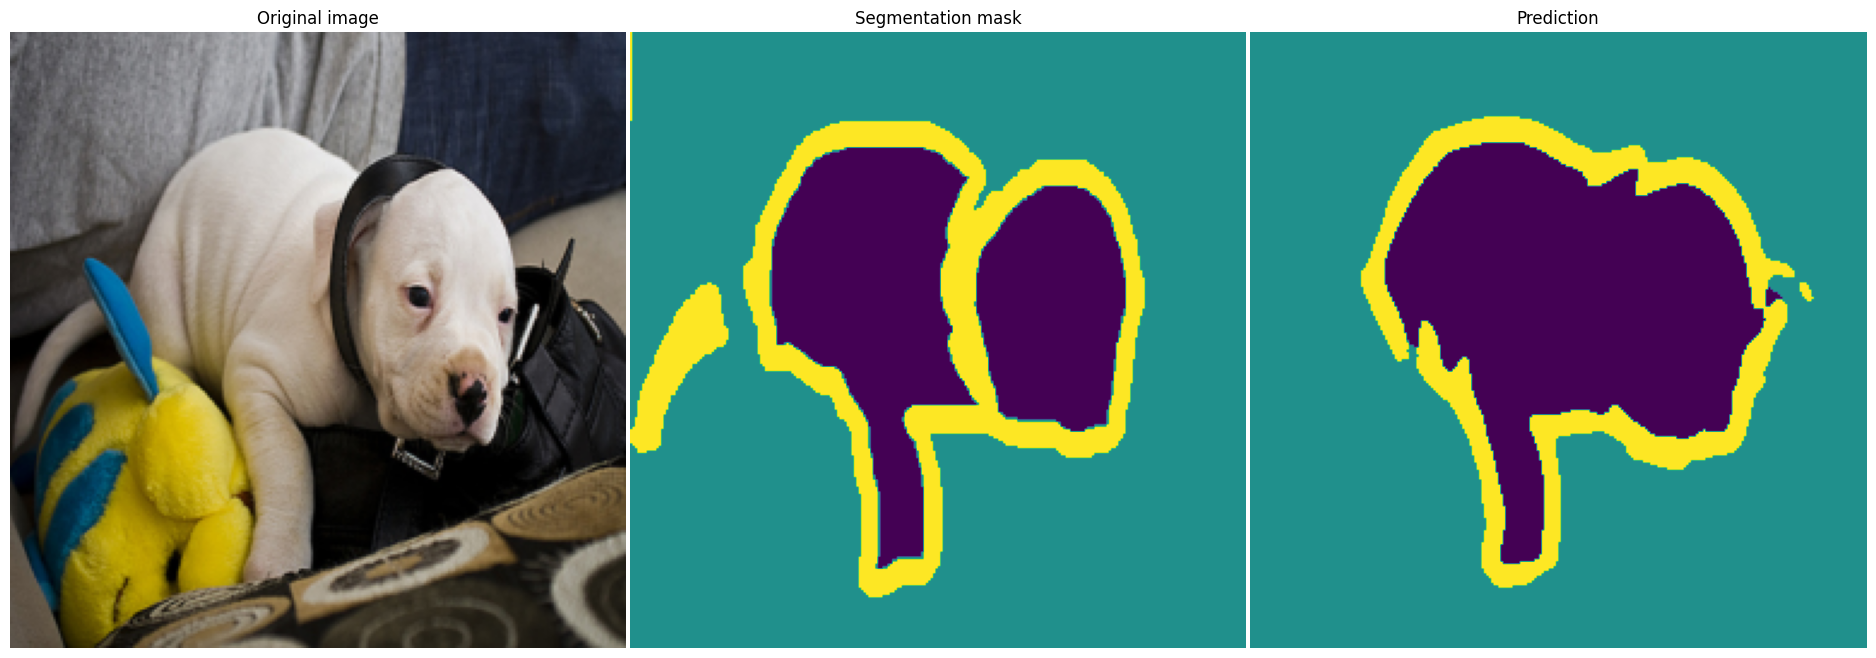

In [30]:
#!g1.1
whole_train_valid_cycle(model, 15, 'UNET segmentation')

In [28]:
import gc
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

GPU:0
process       3366 uses     5853.000 MB GPU memory


In [31]:
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

In [32]:
idx

array([1544, 2840, 1859,   79, 1930,  350, 1972, 1890,   53, 1602, 1550,
        802, 1009, 2800,  280, 1679, 3300, 1899, 1340, 3642, 2960, 1531,
       1673, 3165, 2134, 2434, 1691, 1900, 1924, 2463,  897, 3213, 2805,
       1747,  612, 1028, 2651, 2883,  135, 2097, 3503, 2365,  782, 3015,
        763, 3408,    2,  889,  617, 2526, 1427, 2111, 3253,  283, 3310,
       1393, 2992, 3375,  806, 2220,  274, 2240, 3000, 2978,  437, 1738,
        273, 1608, 1549,  618, 3102,   17, 3125, 2116,  488, 3419, 2523,
       2003, 2741, 2894, 3072,   13, 1209, 1484, 2410,  131, 2630, 1667,
       1236,  394, 1239, 3574,  495,  643, 2921, 1200, 3252, 1835, 2084,
       1797,  839, 2086, 3286, 1118, 2786, 1194, 2900, 2143, 1650, 1100,
       2362, 2150,  938, 2454, 3328, 2810, 1719,  226,  915, 1845, 2244,
        446,  818, 1476, 2467,  407,  765, 3593, 2992, 3568, 1813,  409,
       3510,  262, 1701, 1894, 3194, 1652, 1210, 3367, 1758, 1843, 2334,
        889, 2626,  243, 2968,  439, 2321,  813, 15

In [34]:
validset = torch.utils.data.Subset(valid_dataset, idx)

In [35]:
validloader = torch.utils.data.DataLoader(validset, batch_size=4,shuffle=False, num_workers=2)

In [115]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []
    
    for x, y in loader:
        x,y = x.to(device), y.to(device)
        
        output = model(x)
        pred = torch.argmax(output, dim=1)
        preds.append(pred)
        
    return torch.cat(preds)

In [116]:
test = predict(model, validloader, device)

In [118]:
test

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1,

In [124]:
test.reshape([200, 1, 256, 256])[0]

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0')

In [125]:
torch.save(test.reshape([200, 1, 256, 256]).to(torch.uint8), 'test5.pt')